# Трифонов Никита Дмитриевич  
### trifonov28rus@gmail.com  
### tg: @qwertypine

# Задание 1: Ряды событий  
Дан временной ряд ежедневных наблюдений за числом некоторых событий, происходящих на определенном объекте. Проведите разведочный анализ статистики этого ряда, постройте необходимые модели, и выполните прогноз числа событий в последующие 1, 3 и 10 дней. Обоснуйте точность Ваших прогнозов. Опишите Ваше решение, и приложите, пожалуйста, тексты программ. Если были использованывнешние компоненты и библиотеки, то укажите их. Предпочтителен язык R. Приложение: файл task1.txt

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization
from time import *
from math import fabs
from scipy.stats import invgauss
import scipy
import random
import json
import math
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
%matplotlib inline
%pylab inline

# задаем для воспроизводимости результатов
np.random.seed(42)

import filecmp
import os
import subprocess
import tempfile
import librosa
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytest
import seaborn as sb
import tqdm

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/home/user/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'random', 'fabs']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

### Датасет

In [3]:
#работа с датасетом
df1 = pd.read_csv('/home/user/Programs/Svyaznoy/task1.txt', encoding = "ISO-8859-1")

seasonal_decompose требует наличия времени вместо индексов. Нам известно,что данный временной ряд - ряд ежедневных наблюдений зачислом некоторых событий, возьмем 1/1/2018 как начало.

In [4]:
df1.index = pd.date_range(start='1/1/2018', periods=999)

In [5]:
df1

,1
2018-01-01,2
2018-01-02,4
2018-01-03,2
2018-01-04,2
2018-01-05,4
...,...
2020-09-21,2
2020-09-22,3
2020-09-23,2
2020-09-24,1


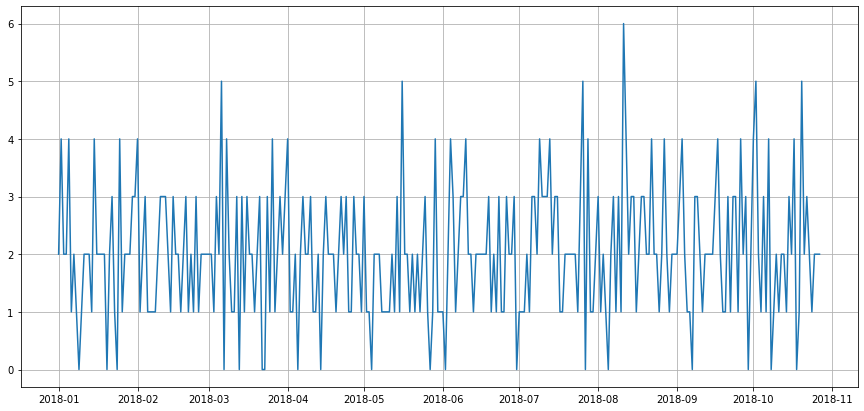

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(df1['1'].iloc[0:300])
plt.grid(True)
plt.show()

In [7]:
import statsmodels.api as sm

TypeError: 'Figure' object is not subscriptable

<Figure size 1080x720 with 0 Axes>

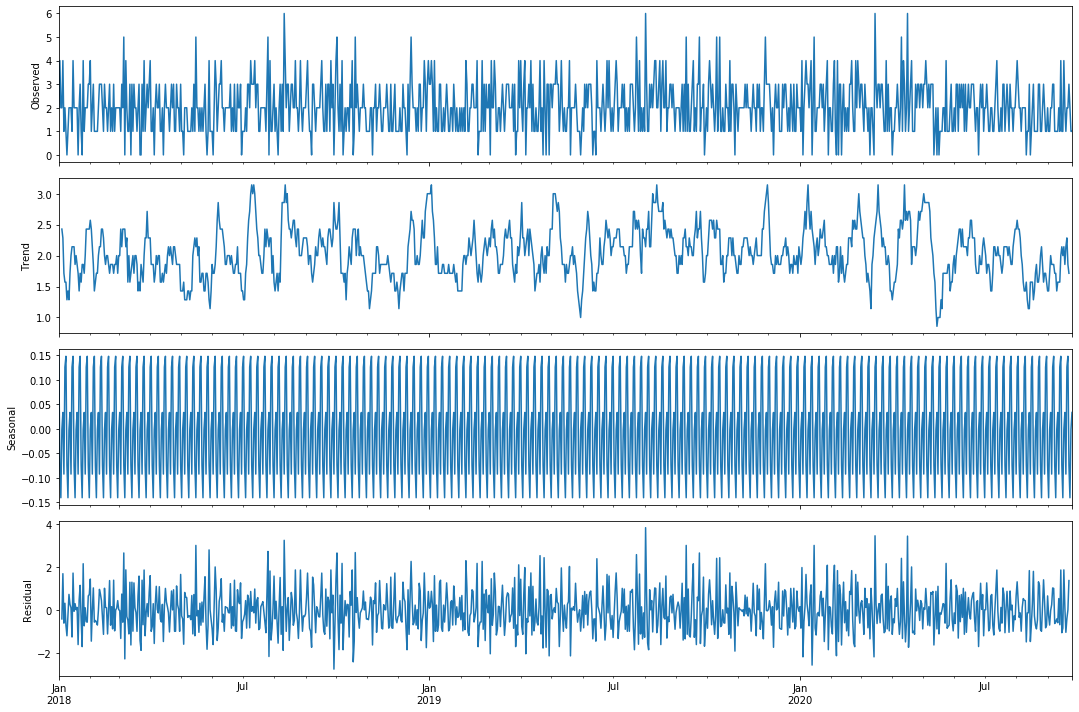

In [8]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df1).plot()[0]

#### Будем постепенно уменьшать рассматриваемую область

TypeError: 'Figure' object is not subscriptable

<Figure size 1080x720 with 0 Axes>

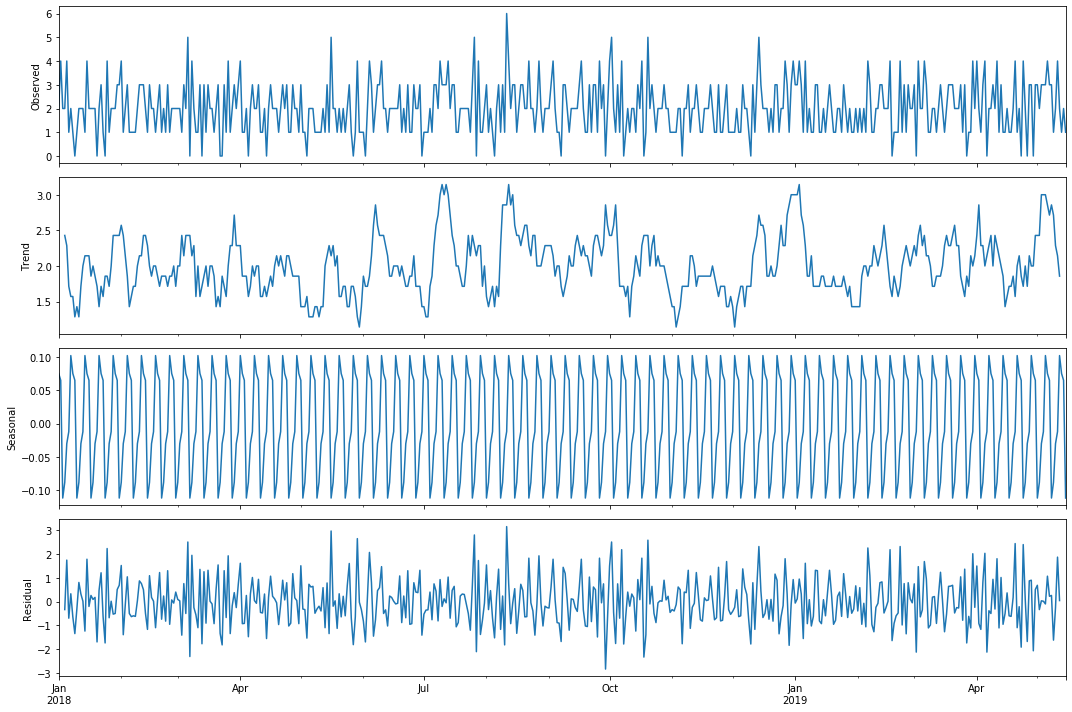

In [9]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df1[:500]).plot()[0]

In [ ]:
plt.figure(figsize(15,10))
p1 = sm.tsa.seasonal_decompose(df1[:100]).plot()[0]

Сразу заметна сезонность.

## Стационарность: критерий Дики-Фуллера

Для использования следующих моделей, в т.ч. скользящего среднего, необходимо проверить на стационарность.

Модели авторегрессии и скользящего среднего строятся исходя из условия стационарности. Стационарный процесс в сильном смысле — это процесс, в котором распределение случайной величины не изменяется со временем, а в слабом — это процесс с постоянным математическим ожиданием и дисперсией, в котором ковариация между значениями ряда зависит только от величины лага.

In [10]:
print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(df1['1'])[1])

Критерий Дики-Фуллера: p = 2.0033250799229536e-22


In [11]:
test = sm.tsa.adfuller(df1.iloc[:,0].values)
print('adf: ', test[0] )
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -12.102501564199173
p-value:  2.0033250799229536e-22
Critical values:  {'1%': -3.4369525024039884, '5%': -2.8644550095200705, '10%': -2.568322093455802}
единичных корней нет, ряд стационарен


## Автокорреляционная и частично автокорреляционная функции  
Посмотрим на ACF и PACF полученного ряда:

In [12]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

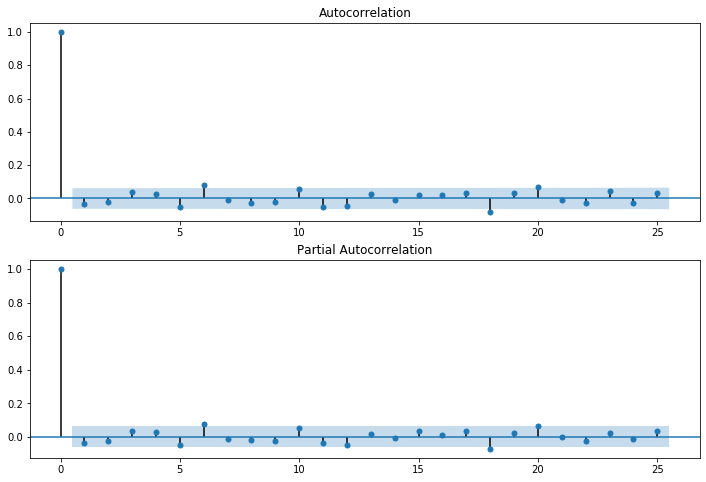

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1, lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1, lags=25, ax=ax2)

Начальные приближения: Q=1, q=0, P=1, p=0

Сделаем перебор параметров.

In [14]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [15]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df1, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3min 11s, sys: 1.08 s, total: 3min 12s
Wall time: 2min 15s


In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
11  (0, 2, 1, 1)  3042.491603
59  (4, 2, 1, 1)  3042.544040
19  (1, 1, 1, 1)  3042.588218
7   (0, 1, 1, 1)  3042.658579
31  (2, 1, 1, 1)  3043.966199


In [18]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  1   No. Observations:                  999
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 12)   Log Likelihood               -1516.246
Date:                            Fri, 24 Jul 2020   AIC                           3042.492
Time:                                    13:25:49   BIC                           3066.960
Sample:                                01-01-2018   HQIC                          3051.798
                                     - 09-25-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0386      0.031    -32.972      0.000      -1.100      -0.977
ma.L2          0.0479      0.032   

Её остатки:

Критерий Стьюдента: p=0.585254
Критерий Дики-Фуллера: p=0.000000


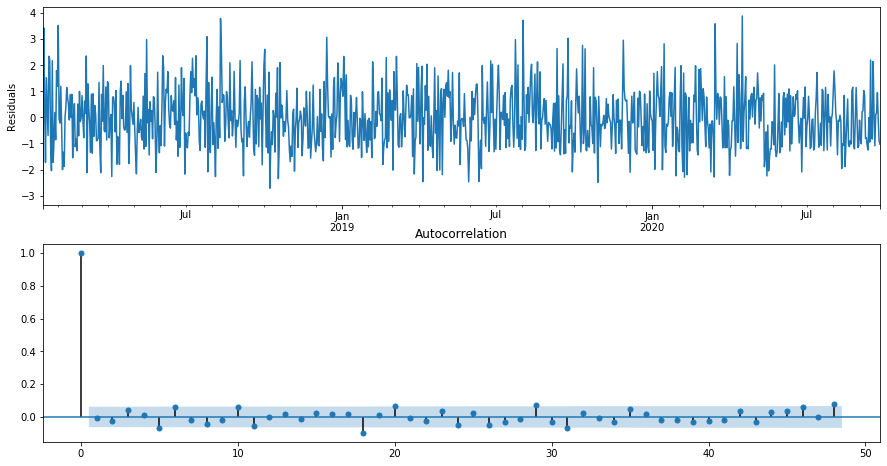

In [19]:
from scipy import stats
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

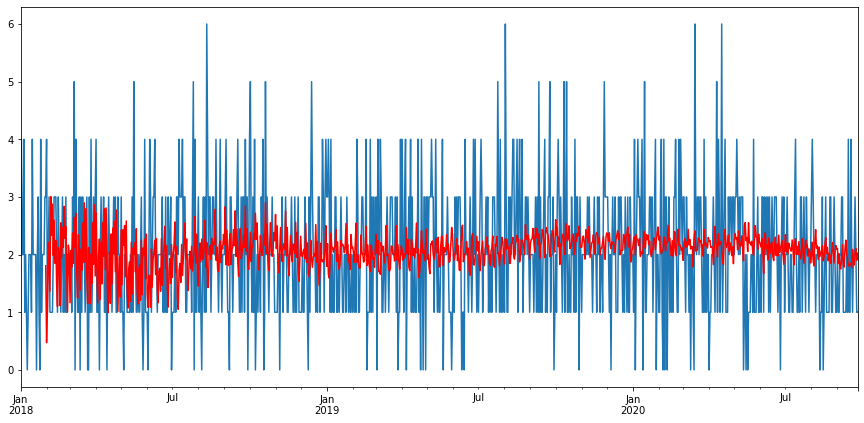

In [20]:
df1['model'] = best_model.fittedvalues
plt.figure(figsize(15,7))
df1['1'].plot()
df1.model[30:].plot(color='r')
pylab.show()

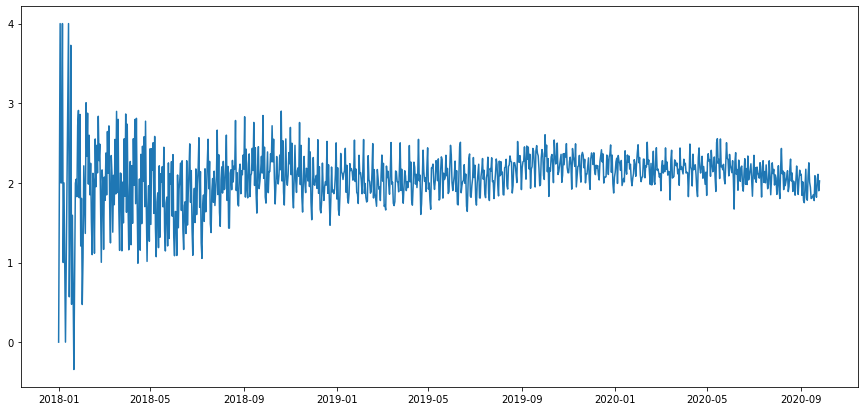

In [21]:
plt.plot(best_model.fittedvalues)

### Линейная регрессия

In [22]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test



In [23]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test


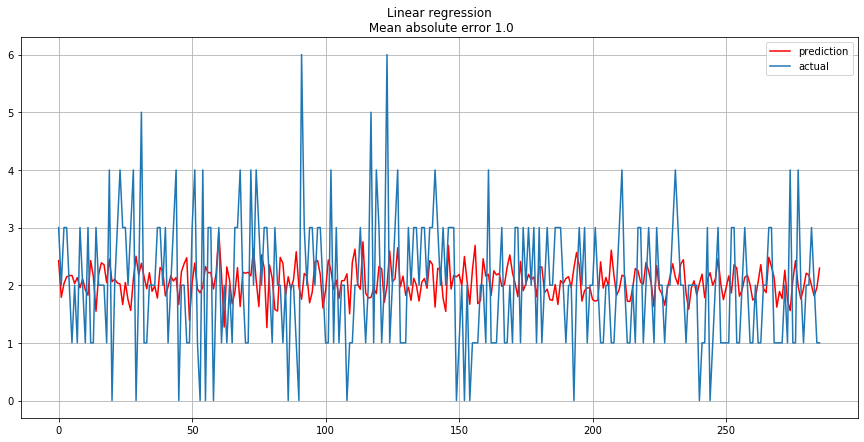

In [24]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(df1['1'], test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

## Скользящее среднее

In [25]:
def moving_average(series, n):
    return np.average(series[-n:])

In [26]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(df1[n:], label="Actual values")

    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xlim(0, 300)

In [27]:
df1 = pd.read_csv('/home/user/Programs/Svyaznoy/task1.txt', encoding = "ISO-8859-1")

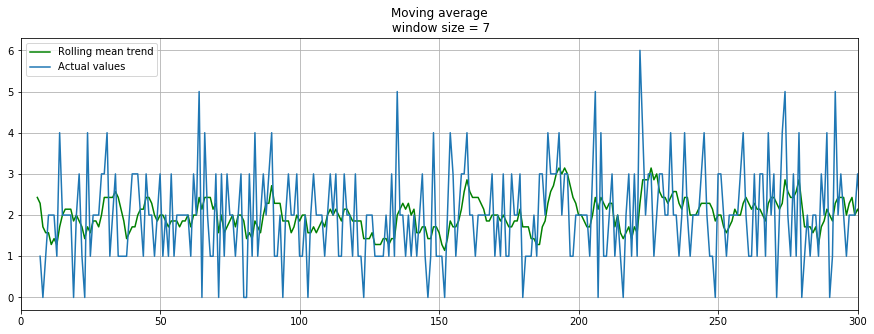

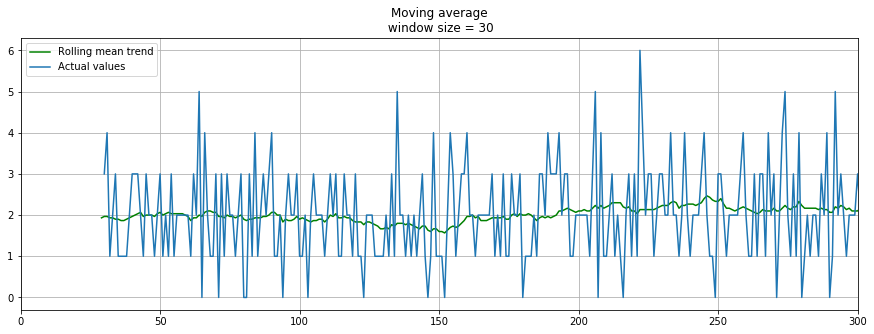

In [28]:
plotMovingAverage(df1, 7) # сглаживаем по неделям
plotMovingAverage(df1, 30) # сглаживаем по месяцам

## Экспоненциальное сглаживание

### Простое экспоненциальное сглаживание

In [29]:
def exponential_smoothing(series, alpha):
    result = [series.iloc[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])
    return result

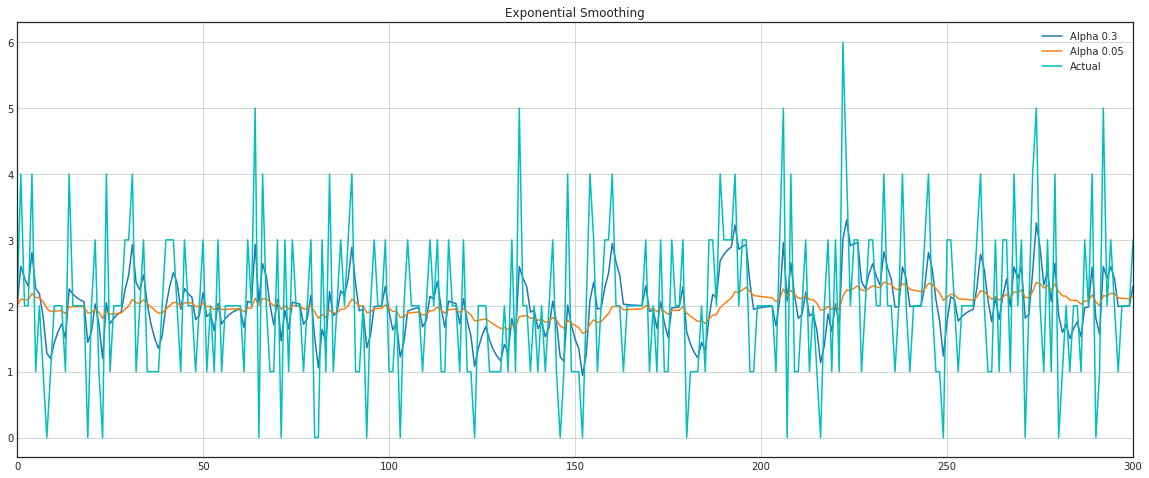

In [30]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(df1, alpha), label="Alpha {}".format(alpha))
    plt.plot(df1, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)
    plt.xlim(0,300)

### Двойное экспоненциальное сглаживание

In [31]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series.iloc[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series.iloc[0], series.iloc[1] - series.iloc[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series.iloc[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

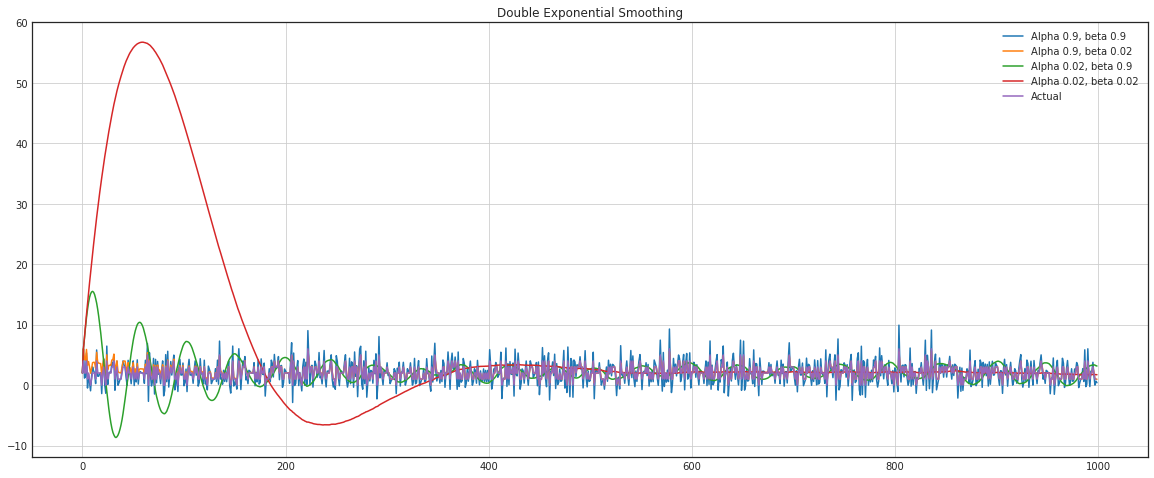

In [32]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(df1, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(df1, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

#### То же самое, но обрезано

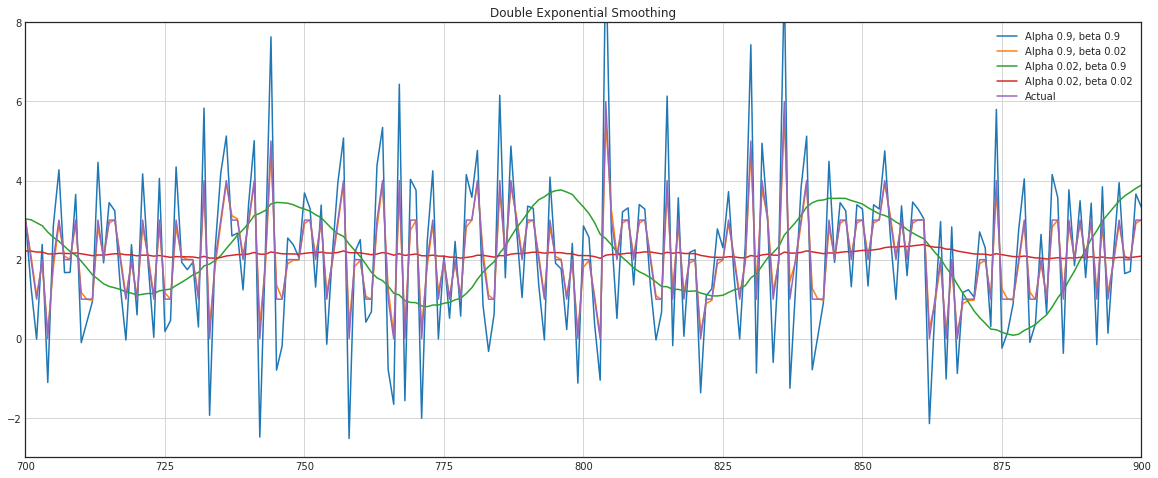

In [33]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(df1, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(df1, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    plt.xlim(700,900)
    plt.ylim(-3,8)

(600, 900)

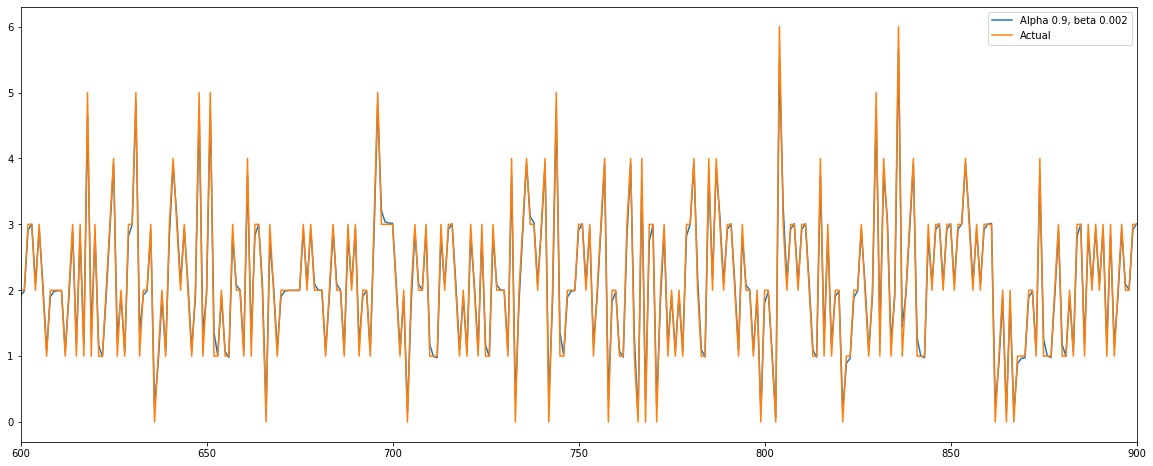

In [34]:
plt.figure(figsize=(20, 8))
plt.plot(double_exponential_smoothing(df1, 0.9, 0.02), label="Alpha 0.9, beta 0.002")
plt.plot(df1, label = "Actual")
plt.legend()
plt.xlim(600,900)

Теперь настраивать пришлось уже два параметра — $alpha$ и $beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй — за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд.

Сделаем фунцию, которая на основе двойного экспоненциального сглаживания предсказывает следующие значения.

In [82]:
# num - сколько точек необходимо предсказать
def pred_DES(df, num):
    series = df.copy()
    for i in range(num+1):
        pred = float(double_exponential_smoothing(series, 0.9, 0.02)[-1].values)
        series.loc[len(series)] = [pred]
        
    return series[(-num-1):-1]

Оценим САО для прогноза на один день.

In [124]:
from sklearn.metrics import mean_absolute_error

Эта модель подходит для предсказания на один день вперед.

Оценим САО для прогноза на один день.

In [126]:
MAE = []
for i in range(25): #25 - число тестовых точек
    pred = pred_DES(df1.iloc[:900+i], 1).values
    actual = df1.iloc[900+i].values
    MAE.append(mean_absolute_error(pred, actual))

In [127]:
np.mean(MAE)

0.8609256595372401

Далее можно рассмотреть RNN и LSTM, GB и деревья решений, т.к. ARMA и модель линейной регрессии дают плохие результаты.   Также, следует провести более качесвенную проверку моделей, например через кросс-валидацию.  
На этом базовое рассмотрение закончено.